In [1]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
#data
L= 0.3 # module length in meters
n_f = 6 #number of fibers
i_d = 1.27e-3#internal diameter m
p_s = 0.1e-6 #pore size in meters
T = 298 #K
gamma_w = 32400 #shear rate s-1
phi_m = 0.68
eta_0 = 0.001#Pa.second viscosity of hte TGM
rho_p = 1300 #kg/m3 density of the particles
rho_f = 1000 #kg/m3 density of the fluid
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant
phi_w_guess = [0.64,0.64,0.64] #guess for the volume fraction of solute at the membrane wall
# Particle sizes (in meters)
particles = [
    {'name': '10nm', 'radius': 10e-9, 'phi_b': 0.01},
    {'name': '180nm', 'radius': 180e-9, 'phi_b': 0.05},
    {'name': '300nm', 'radius': 300e-9, 'phi_b': 0.06}
]
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
target_species = 10e-9 
#equations
#Step 2 - evaluate the viscosity
    # no particle-particle interactions - dillute suspensions
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    eta_phi = eta_0*(1+5/2*phi_b+k1*phi_b**2)
    return eta_phi
eta_f = viscosity_no_PP(eta_0,sum(particles['phi_b'] for particles in particles),9.8)
# print(eta_f)
eta_f = 0.00131
diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * target_species)

#k1 around 10 for spheres
#not sure about the shape factor

def max_agg_packing (phi_m):
    phi_Max=phi_m+0.74*(1-phi_m)
    return phi_Max
phi_M = max_agg_packing(phi_m)
# phi_M = 0.92

#step 3 - maximum back-transport velocity, u (m/s)- Brownian, shear-infuced and intertial lift - Full retention of all solutes
 #particle volume franction at the membrane wall for each particle size for the first iteration
#J_flux = 30 #LMH


def J_brownian(a, phi_w, phi_b):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    J = 0.114 * term * math.log(phi_w / phi_b)
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b):
    term = (a ** 4 / L) ** (1/3)
    log_term = math.log(phi_w / phi_b)
    J = 0.078 * term * gamma_w * abs(log_term)
    return J

# Function to calculate J for inertial lift
def J_inertial(a):
    J = (0.036 * rho_p * (a ** 3) * (gamma_w ** 2)) / eta_f
    return J
#J solvent permeation flux (m/s)


size_vel_dict = {}
set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])

def min_flux(Particles, phi_w_list):
    
    min_velocity = float('inf')
    selected_particle_radius = None

    for particle, phi_w in zip(Particles, phi_w_list):
        a = particle['radius']
        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w, phi_b)
        shear_velocity = J_shear(a, phi_w, phi_b)
        inertial_velocity = J_inertial(a)
        
        # Find the maximum velocity
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        
        # Determine the source of the maximum velocity
        source = 'brownian' if max_velocity == brownian_velocity else 'inertial' if max_velocity == inertial_velocity else 'shear'
        
        # Replace or update size_vel_dict
        size_vel_dict[particle['name']] = max_velocity
        
        # Update set_data by replacing previous row or adding a new one
        if particle['name'] in set_data['name'].values:
            set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
        else:
            set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
        
        # Check for the minimum velocity
        if max_velocity < min_velocity:
            min_velocity = max_velocity
            selected_particle_radius = a

    return selected_particle_radius, min_velocity, set_data

# Initialize variables for particles and inertial-lift properties
ai_target, min_vel, dataf= min_flux(particles, phi_w_guess)

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data):
    count = 0
    # Dictionaries to store results
    phi_w_J_dict = {}
    phi_wjI_dict = {}
    inertial_particles = []
    
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            
            # Use the source to choose the max_velocity
            if source == 'inertial':
                max_velocity = J_inertial(a_particle)
            elif source == 'shear':
                max_velocity = J_shear(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            elif source == 'brownian':
                max_velocity = J_brownian(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            else:
                raise ValueError(f"Unknown source {source} for particle {a_particle}")

            if max_velocity >= 10 * min_velocity and source == 'inertial':
                # Handle inertial particles
                phi_wjI = 0
                phi_wjI_dict[a_particle] = phi_wjI
                phi_w_dict[a_particle] = phi_wjI
                phi_w_J_dict[a_particle] = phi_wjI
                inertial_particles.append((a_particle, phi_b_particle, max_velocity))
                count += 1
            else:
                # Define the objective function based on the source
                def objective_function(phi_w_particle):
                    # Recalculate velocities based on the current wall concentration phi_w_particle
                    if source == 'brownian':
                        max_velocity = J_brownian(a_particle, phi_w_particle, phi_b_particle)
                    elif source == 'shear':
                        max_velocity = J_shear(a_particle, phi_w_particle, phi_b_particle)
                    elif source == 'inertial':
                        max_velocity = J_inertial(a_particle)
                    return abs(max_velocity - min_velocity)

                # Minimize the objective function to find the optimal phi_w for the particle
                result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                if result.success:
                    phi_w_optimal = result.x
                    phi_w_dict[a_particle] = phi_w_optimal
                    phi_w_J_dict[a_particle] = phi_w_optimal
                else:
                    print(f"Optimization failed for particle radius {a_particle:.1e} m")
    
    # Handle inertial particles after processing all particles
    if count == 1:
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = phi_M - sum(phi_w_J_dict.values())
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI
    elif count > 1:
        total_u_j_inv = sum((phi_b / u_j) for _, phi_b, u_j in inertial_particles)
        phi_w_remaining = phi_M - sum(phi_w_J_dict.values())
        phi_w_jI_sum = sum((phi_b / u_j) / total_u_j_inv * phi_w_remaining for _, phi_b, u_j in inertial_particles)
        if abs(phi_M - (sum(phi_w_J_dict.values()) + phi_w_jI_sum)) > 1e-6:
            print("Warning: φ_M and the sum of φ_w_j do not match closely enough.")
        
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = (phi_b / u_j) / total_u_j_inv * phi_w_remaining
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI

    return phi_w_dict


# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
target_dict = {}
def packing_constraints(Particles, phi_w_list):
    ai_target, min_vel, dataf= min_flux(Particles, phi_w_list)
    phi_w_updated=calculate_phi_w(Particles, ai_target, min_vel, dataf)
    
    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 1000
    smallest_key = min(phi_w_updated.keys())

    for i in range(max_iterations):
        remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != smallest_key}
        phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
        # Check if packing constraints are satisfied
        if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_updated[smallest_key] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smallest_int<0.74:
            print(f"Iteration {i}: Packing constraints are met.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
        
        # Store the previous values of phi_w for comparison
        phi_w_previous = phi_w_updated.copy()
        # Update phi_w for the target particle
        phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
        phi_w_updated[ai_target] = phi_w_i_corrected
        phi_w_updated_list = list(phi_w_updated.values())
        #print(phi_w_updated, J_flux, a_target)
        # Recalculate the flux and phi_w_j values after updating
        ai_target, min_vel, dataf= min_flux(particles, phi_w_updated_list)
        phi_w_updated=calculate_phi_w(particles, ai_target, min_vel, dataf)
        phi_smallest_int= phi_w_dict[min(phi_w_dict.keys())] / (1 -sum(phi_w for phi_w in phi_w_dict.values() if phi_w != phi_w_dict[min(phi_w_dict.keys())]))
#        # #step - 9 - calculate the minimum
        r_minimum = (min(phi_w_dict.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
        
        # Check for the change in phi_w values between iterations
        target_dict[ai_target] = min_vel
        phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)

        # If the change in phi_w values is smaller than the tolerance, stop the iteration
        if phi_w_diff < tolerance:
            print(f"Iteration {i}: Will not converger further.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
    # If the loop completes without finding a solution
    print("Warning: No solution found within the iteration limit.")
  
    return phi_w_updated, min_vel, ai_target, dataf,r_minimum, phi_smallest_int


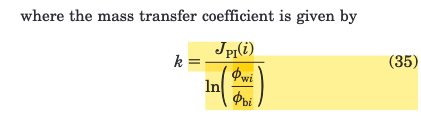

In [2]:
#mass-transfer coefficient calculated from equation  1#step 10
mass_transfer={}
def sieving_parameters(Particles, phi_w_list):
    phi_w_updated, J_flux, ai_target, dataf, r_min, phi_smal_int = packing_constraints(Particles, phi_w_list)
    print(f"Updated phi_w_dict: {phi_w_updated}. J_flux: {J_flux}")
    print(f"phi_smallest_int: {phi_smal_int:.6f}")
    print(f"Minimum transmission gap {min(phi_w_updated.keys())}: {r_min} m")
    S_O_previous = 0  # Sieving coefficient from the previous iteration

    for i in range(50):
        Q=J_flux *n_f*math.pi*i_d*(L+L/20)
        mass_transfer_k = 1.62 * (diffusion_coeff/i_d)*(((4*rho_f*Q)/(math.pi*n_f*i_d*eta_f))**(1/3))*((eta_f/(rho_f*diffusion_coeff))**(1/3))
        print(f"mass transfer coefficient: {mass_transfer_k}")
        lambda_s_min = target_species / r_min
        print(f"lambda_s_min: {lambda_s_min}")
        Sieving_coeff_int = ((1 - lambda_s_min) ** 2) * (2 - ((1 - lambda_s_min) ** 2)) * math.exp(-0.7146 * (lambda_s_min ** 2))
        print(f"Initial Sieving coefficient: {Sieving_coeff_int}")
        delta_m = target_species * ((4 * (4 / 3) * math.pi) / phi_smal_int) ** (1 / 3)
        print(f"delta_m: {delta_m}")
        phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
        print(f"phi_e_K_d: {phi_e_K_d}")
        cake_membrane_porosity = 1 - phi_smal_int
        print  (f"cake_membrane_porosity: {cake_membrane_porosity}")

        Peclet_m = ((J_flux * delta_m) / diffusion_coeff) * (Sieving_coeff_int / (cake_membrane_porosity * phi_e_K_d))
        print(f"Peclet_m: {Peclet_m}")
        Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / ((Sieving_coeff_int + math.exp(Peclet_m)) - 1)
        print(f"Actual Sieving coefficient: {Sieving_coeff_act}")
        Sieving_coeff_obs = Sieving_coeff_act / ((1 - Sieving_coeff_act) * math.exp(-J_flux / mass_transfer_k) + Sieving_coeff_act)
        print(f"Observed Sieving coefficient: {Sieving_coeff_obs}")
        yields = 1 - math.exp(-4 * Sieving_coeff_obs)
        print(f"Yields: {yields}")
        # Convergence check for the main loop
        if (abs(S_O_previous-Sieving_coeff_obs)/((S_O_previous+Sieving_coeff_obs)/2)) < 0.1:
            print(f"Convergence reached after {i} iterations.")
            print(f"Final Sieving coefficient (obs): {Sieving_coeff_obs}")
            print(f"Final Yield: {yields}")
            print(f"Final flux: {J_flux}")
            for particle in Particles:
                name = particle['name']
                phi_b = particle['phi_b']
                phi_w = phi_w_updated[particle['radius']]
                print(f"Particle {name}:")
                print(f"  Bulk concentration (phi_b): {phi_b}")
                print(f"  Wall concentration (phi_w): {phi_w}")
            return 
        if yields>0.95:
            print(f"Final iteration {i}")
            print(f"Final Sieving coefficient (obs): {Sieving_coeff_obs}")
            print(f"Final Yield: {yields}")
            print(f"Final flux: {J_flux}")
            for particle in Particles:
                name = particle['name']
                phi_b = particle['phi_b']
                phi_w = phi_w_updated[particle['radius']]
                print(f"Particle {name}:")
                print(f"  Bulk concentration (phi_b): {phi_b}")
                print(f"  Wall concentration (phi_w): {phi_w}")
            return 

        # Update flux if sieving coefficient is within a valid range
        if 0 < Sieving_coeff_obs < 0.75:
            J_flux = mass_transfer_k * math.log((phi_w_updated[target_species] / (Particles[0]['phi_b'] * (1 - Sieving_coeff_obs))))
            print(f"Updated flux: {J_flux}")

        S_O_previous = Sieving_coeff_obs

        # Sub-loop for calculating phi_w and r_min
        for j in range(50):
            phi_w_previous = phi_w_updated.copy()
            phi_w_updated = calculate_phi_w(Particles, ai_target, J_flux, dataf)
            # print(f"Updated phi_w_dict: {phi_w_updated} calculate phw-w-j")
            smallest_key = min(phi_w_updated.keys())
            print(dataf)
            # Correction of wall concentration
            phi_w_i = phi_w_updated[ai_target]
            # print(ai_target)
            phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
            phi_w_updated[ai_target] = phi_w_i_corrected
            # print(f"Updated phi_w_dict: {phi_w_updated} corrected_i")
            ai_target, J_flux, dataf = min_flux(Particles, phi_w_updated.values())
            remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != smallest_key}
            # Packing constraints calculation
            phi_smal_int = phi_w_updated[min(phi_w_updated.keys())] / (1 - sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_updated[min(phi_w_updated.keys())]))
            r_min = (min(phi_w_updated.keys()) * ((math.sqrt(2) * (((4 * (4 / 3) * math.pi) / phi_smal_int)) ** (1 / 3)) - 2))/2
            # Check for packing constraint fulfillment
            if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_updated[smallest_key] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smal_int < 0.74:
                
                print(f"Packing constraints are met:{j}")
                print(f"Updated phi_w_dict: {phi_w_updated}")
                print(f"Updated flux: {J_flux}")
                break
            
            # Convergence check for sub-loop
            phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)
            if phi_w_diff**2 < 1e-6:
                print(f"Sub-loop convergence reached after {j} iterations.")
                break
    print("Warning: No solution found within the iteration limit.")
    return

print(sieving_parameters(particles, phi_w_guess))


Iteration 1: Packing constraints are met.
Updated phi_w_dict: {1e-08: 0.27264646152606287, 1.8e-07: 0.4340560894637942, 3e-07: 0.17911090202630395}. J_flux: 8.291776711125013e-06
phi_smallest_int: 0.704817
Minimum transmission gap 1e-08: 1.0331796565466913e-08 m
mass transfer coefficient: 1.8191506229078623e-06
lambda_s_min: 0.967885878959724
Initial Sieving coefficient: 0.0010555144890736336
delta_m: 2.8753502450294018e-08
phi_e_K_d: 1.9060407425466684e-07
cake_membrane_porosity: 0.2951830492017491
Peclet_m: 268.44293584487116
Actual Sieving coefficient: 0.0010555144890736336
Observed Sieving coefficient: 0.0915693099641958
Yields: 0.30668943875800847
Updated flux: 6.188072848864529e-06
    name        radius  max_velocity    source
0   10nm  1.000000e-08      0.000010  brownian
1  180nm  1.800000e-07      0.000008     shear
2  300nm  3.000000e-07      0.000010     shear
    name        radius  max_velocity    source
0   10nm  1.000000e-08      0.000006  brownian
1  180nm  1.800000e-0

In [3]:
particles[0]['phi_b']


0.01